<a href="https://colab.research.google.com/github/Lele237/-MachineLearning/blob/main/Visualiza%C3%A7%C3%A3o_de_dados_com_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Grafo de similaridade

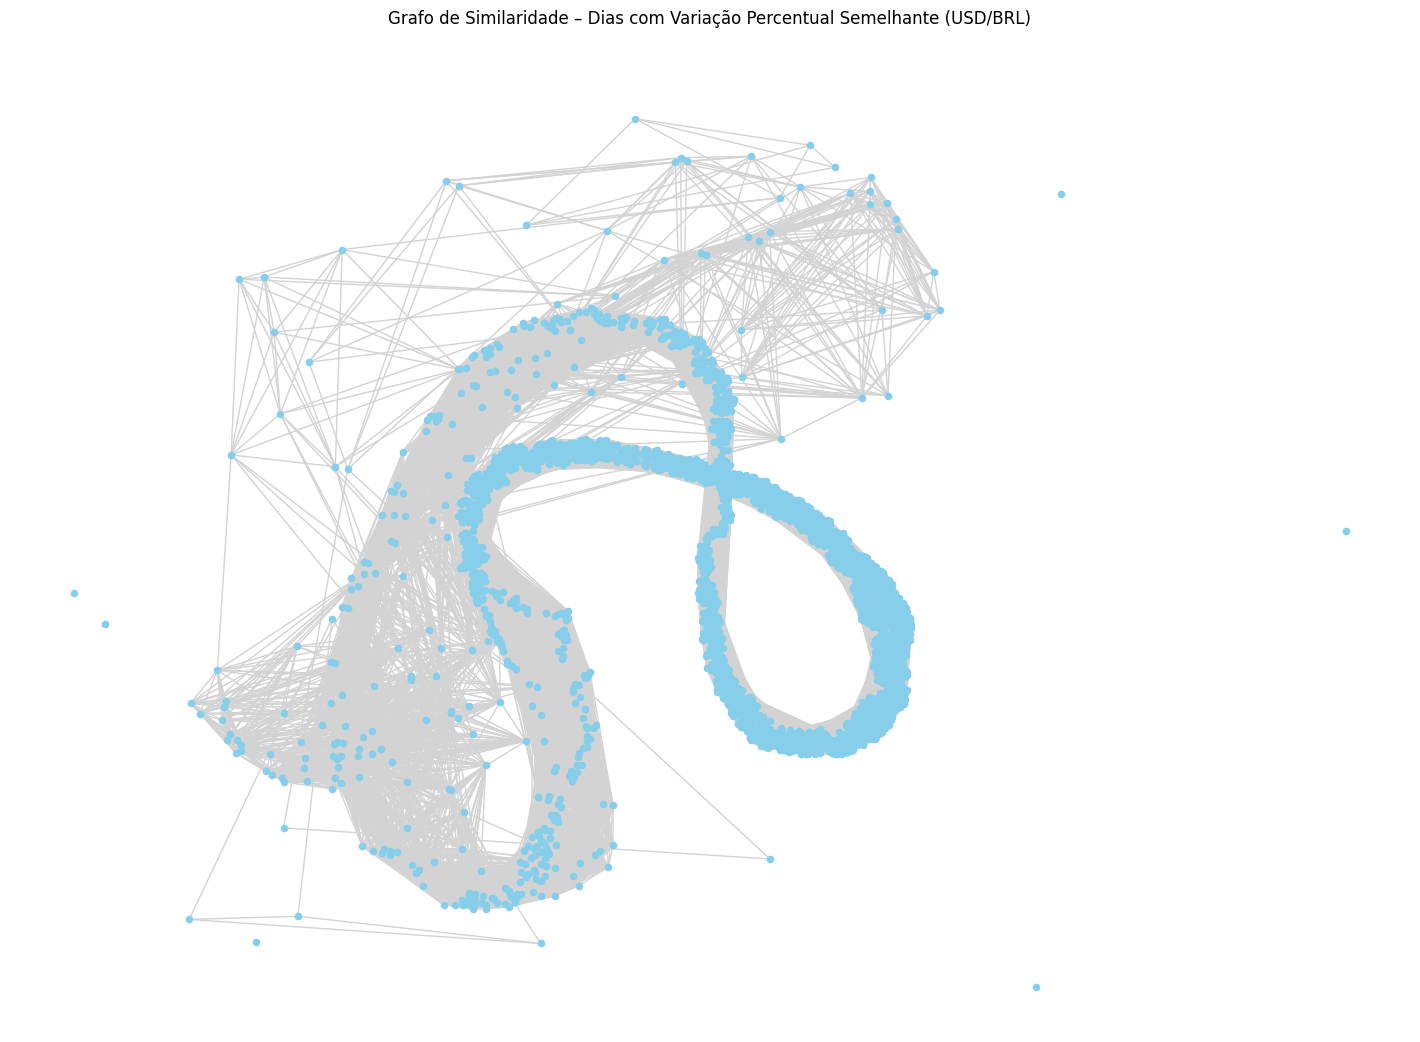

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Carregar e preparar os dados
df = pd.read_csv("USD_BRL_hist.csv")
df['Data'] = pd.to_datetime(df['Data'], format="%d.%m.%Y")
df = df.sort_values(by='Data').reset_index(drop=True)
df['Variação (%)'] = df['USD_BRL'].pct_change() * 100

# Inicializar o grafo
G = nx.Graph()

# Adicionar nós com data e atributo de variação
for i, row in df.iterrows():
    if pd.notna(row['Variação (%)']):
        data_str = row['Data'].strftime("%Y-%m-%d")
        G.add_node(data_str, variacao=row['Variação (%)'])

# Conectar nós com variações parecidas (diferença < 0.2%)
threshold = 0.2
nodes = list(G.nodes(data=True))

for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        v1 = nodes[i][1]['variacao']
        v2 = nodes[j][1]['variacao']
        if abs(v1 - v2) < threshold:
            G.add_edge(nodes[i][0], nodes[j][0])

# Desenhar o grafo
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=0.2)
nx.draw(
    G, pos,
    with_labels=False,
    node_size=20,
    node_color='skyblue',
    edge_color='lightgray'
)
plt.title("Grafo de Similaridade – Dias com Variação Percentual Semelhante (USD/BRL)")
plt.show()


In [ ]:
# Node-Link Tree

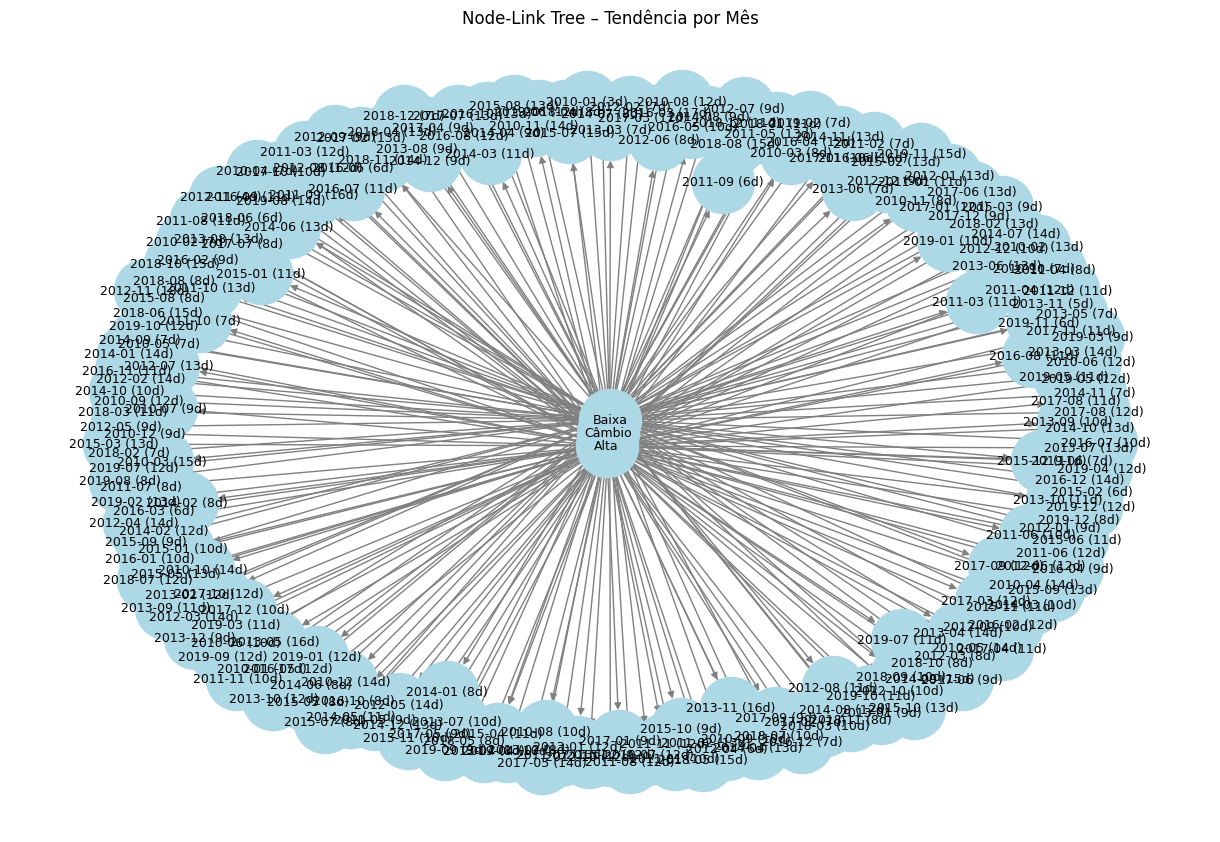

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Preparar dados
df = pd.read_csv("USD_BRL_hist.csv")
df['Data'] = pd.to_datetime(df['Data'], format="%d.%m.%Y")
df = df.sort_values(by='Data').reset_index(drop=True)
df['Variação (%)'] = df['USD_BRL'].pct_change() * 100

def classificar_tendencia(x):
    if pd.isna(x):
        return None
    elif x > 0:
        return 'Alta'
    elif x < 0:
        return 'Baixa'
    else:
        return 'Estável'

df['Tendência'] = df['Variação (%)'].apply(classificar_tendencia)
df['Ano-Mês'] = df['Data'].dt.to_period('M').astype(str)

# Filtrar apenas Alta e Baixa
filt_df = df[df['Tendência'].isin(['Alta', 'Baixa'])]

# Contar dias por tendência e mês
resumo = filt_df.groupby(['Tendência', 'Ano-Mês']).size().reset_index(name='Dias')

# Criar grafo tipo árvore
G = nx.DiGraph()

G.add_node("Câmbio")

for tendencia in resumo['Tendência'].unique():
    G.add_edge("Câmbio", tendencia)
    meses = resumo[resumo['Tendência'] == tendencia]
    for _, row in meses.iterrows():
        G.add_edge(tendencia, f"{row['Ano-Mês']} ({row['Dias']}d)")

# Desenhar
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=9, edge_color='gray')
plt.title("Node-Link Tree – Tendência por Mês")
plt.show()


In [ ]:
# Diagrama de Gantt

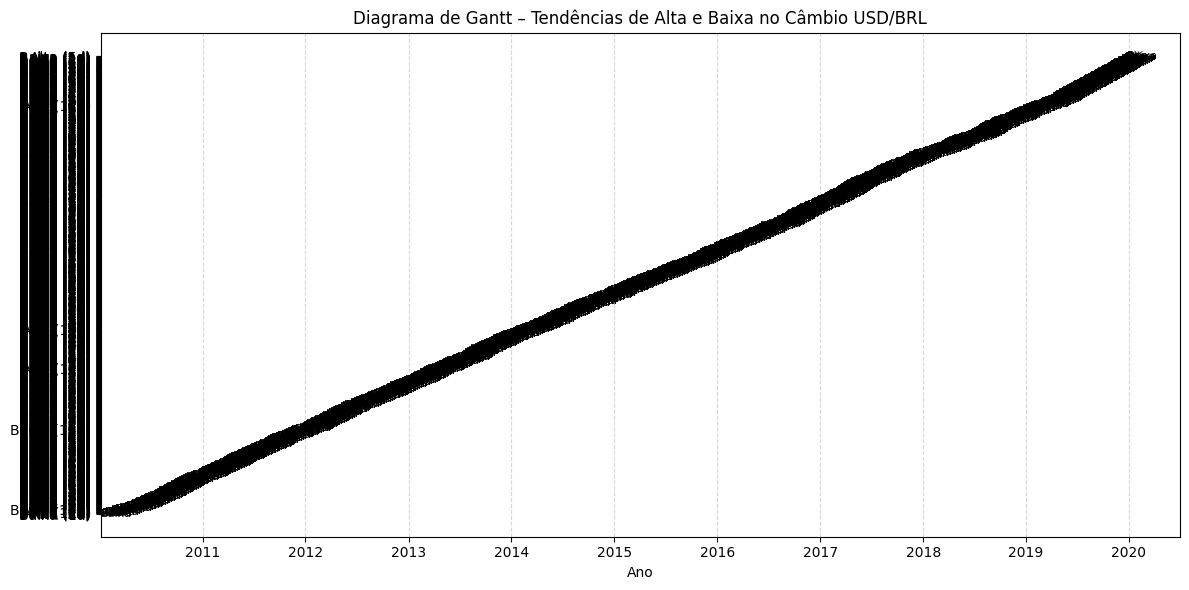

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Carregar o dataset
df = pd.read_csv("USD_BRL_hist.csv")

# Converter data e ordenar
df['Data'] = pd.to_datetime(df['Data'], format="%d.%m.%Y")
df = df.sort_values(by='Data').reset_index(drop=True)

# Calcular variação percentual
df['Variação (%)'] = df['USD_BRL'].pct_change() * 100

# Classificar tendência
def classificar_tendencia(x):
    if pd.isna(x):
        return None
    elif x > 0:
        return 'Alta'
    elif x < 0:
        return 'Baixa'
    else:
        return 'Estável'

df['Tendência'] = df['Variação (%)'].apply(classificar_tendencia)

# Identificar grupos contínuos
df['Grupo'] = (df['Tendência'] != df['Tendência'].shift()).cumsum()
df['Grupo'] = df.apply(lambda row: None if row['Tendência'] == 'Estável' else row['Grupo'], axis=1)

# Agrupar sequências
gantt_data = df.dropna(subset=['Grupo']).groupby(['Grupo', 'Tendência']).agg(
    Início=('Data', 'first'),
    Fim=('Data', 'last'),
    Duração=('Data', lambda x: (x.max() - x.min()).days + 1)
).reset_index()

# Cores por tendência
colors = {'Alta': 'green', 'Baixa': 'red'}

# Criar o gráfico
fig, ax = plt.subplots(figsize=(12, 6))

for i, row in gantt_data.iterrows():
    ax.barh(i, row['Duração'], left=row['Início'], color=colors[row['Tendência']], edgecolor='black')
    ax.text(row['Início'], i, row['Tendência'], va='center', ha='left', fontsize=8)

# Ajustes de eixo
ax.set_yticks(range(len(gantt_data)))
ax.set_yticklabels([f"{row['Tendência']} ({row['Duração']}d)" for _, row in gantt_data.iterrows()])
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_title('Diagrama de Gantt – Tendências de Alta e Baixa no Câmbio USD/BRL')
ax.set_xlabel('Ano')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
